<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Gaussian Naive Bays
 - <span style="color:dodgerblue;"> **Pros:**
   - <span style="color:black;"> Fast Learner
 - <span style="color:deeppink;"> **Cons:**
   - <span style="color:black;"> Unable To Handle Imbalance

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Objective:
 - To detect diabetes using Gaussian Naive Bayes and Ensemble Methods

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import numpy  as np
from   numpy import mean, std

import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)
from   seaborn import boxplot as BoxPlot

from sklearn.naive_bayes     import GaussianNB

from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import scale, LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics         import recall_score, precision_score, accuracy_score
from sklearn.metrics         import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble        import GradientBoostingClassifier, StackingClassifier, VotingClassifier

from imblearn.combine        import SMOTETomek, SMOTEENN
import time, pickle

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading and Exploring the Data

In [2]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes'
estimated_column = 'Class'

data_file  = 'Pima_Diabetes.csv'
data_sheet = 'Pima_Diabetes'

# needed parameters 
RANDOM_STATE =  3
SCORING      = 'accuracy'

# (auto)
df_raw = pd.read_csv( data_file, header=0 ) # , delimiter=','
print(f'there are {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.')

df_raw.tail() 

there are 768 rows and 9 columns.


,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


#####   

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Random Records

In [3]:
np.random.seed(3)
cm = sns.light_palette('#ffcccb', as_cmap=True)

df_raw.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
1,101,50,15,36,24.20,0.53,26,0
4,156,75,0,0,48.30,0.24,32,1
1,97,66,15,140,23.20,0.49,22,0
2,197,70,99,0,34.70,0.57,62,1
13,106,72,54,0,36.60,0.18,45,0
4,154,62,31,284,32.80,0.24,23,0
5,99,74,27,0,29.00,0.20,32,0
2,68,62,13,15,20.10,0.26,23,0
4,110,92,0,0,37.60,0.19,30,0
6,114,0,0,0,0.00,0.19,26,0


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Exploring The Data (Info & Describe)

In [4]:
print( df_raw.info() )
print('')
df_raw.describe().T.style.format(precision=1)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pregnancy        768 non-null    int64  
 1   Blood_Plasma     768 non-null    int64  
 2   Blood_Pressure   768 non-null    int64  
 3   Skin             768 non-null    int64  
 4   Test             768 non-null    int64  
 5   Body_Mass_Index  768 non-null    float64
 6   Pedi             768 non-null    float64
 7   Age              768 non-null    int64  
 8   Class            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None



,count,mean,std,min,25%,50%,75%,max
Pregnancy,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Blood_Plasma,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
Blood_Pressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
Skin,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Test,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
Body_Mass_Index,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
Pedi,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Class,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - No Empty Cells Found.
 - Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - include 0 which is impossible, and means missing value
 - These 0s must be converted to np.nan

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Converting 0s to np.nan

In [5]:
Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index']

df_missing = df_raw.copy()
for ft in Features_with_Missin_Values:
    df_missing[ft] = df_missing[ft].replace(0,np.nan)
    
df_missing.head(10).style.\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
6,148.00,72.00,35.00,nan,33.60,0.63,50,1
1,85.00,66.00,29.00,nan,26.60,0.35,31,0
8,183.00,64.00,nan,nan,23.30,0.67,32,1
1,89.00,66.00,23.00,94.00,28.10,0.17,21,0
0,137.00,40.00,35.00,168.00,43.10,2.29,33,1
5,116.00,74.00,nan,nan,25.60,0.20,30,0
3,78.00,50.00,32.00,88.00,31.00,0.25,26,1
10,115.00,nan,nan,nan,35.30,0.13,29,0
2,197.00,70.00,45.00,543.00,30.50,0.16,53,1
8,125.00,96.00,nan,nan,nan,0.23,54,1


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Missing Values by KNNImputer

In [6]:
from sklearn.impute import KNNImputer
imputer   = KNNImputer( n_neighbors=2, weights="distance" )   # 'distance', 'uniform'

# Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index'] 
X_Null    = df_missing[ Features_with_Missin_Values ].values.copy()
X_Treated = imputer.fit_transform( X_Null )

In [7]:
df_Treated    = pd.DataFrame(X_Treated, columns=Features_with_Missin_Values)
#df.columns   = [ Features_with_Missin_Values ]
df_no_missing = df_missing.copy()
df_no_missing[ Features_with_Missin_Values ] = df_Treated.copy()
print(f'there are {df_no_missing.shape[0]} rows and {df_no_missing.shape[1]} columns.') 

df_no_missing.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

there are 768 rows and 9 columns.


Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
5,168.00,64.00,36.32,205.82,32.90,0.14,41,1
4,114.00,64.00,18.32,143.04,28.90,0.13,24,0
6,115.00,60.00,39.00,108.12,33.70,0.24,40,1
2,112.00,68.00,22.00,94.00,34.10,0.32,26,0
2,90.00,70.00,17.00,64.99,27.30,0.09,22,0
4,122.00,68.00,28.60,271.80,35.00,0.39,29,0
8,99.00,84.00,25.00,108.73,35.40,0.39,50,0
6,114.00,73.00,35.00,242.50,38.50,0.19,26,0
2,175.00,88.00,30.44,226.70,22.90,0.33,22,0
3,193.00,70.00,31.00,301.25,34.90,0.24,25,1


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - In Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - The 0s are replaced with appropriate values.

** **

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Detecting Outliers by Boxplots

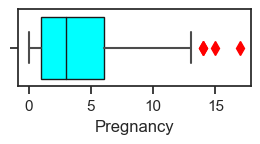

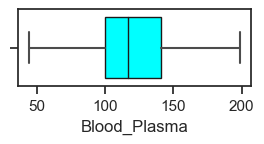

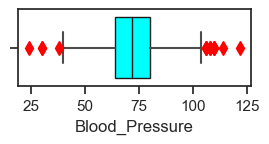

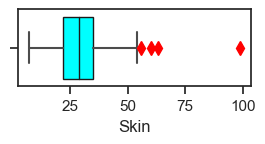

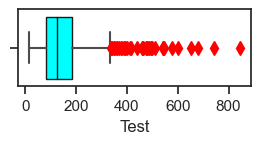

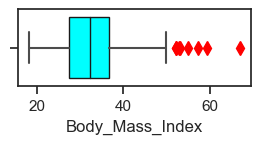

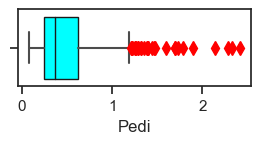

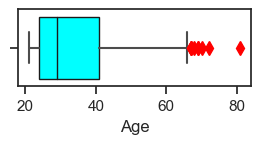

In [8]:
# (auto) 
df = df_no_missing.copy()

scalar_columns = []
for col in df.columns:
    if df[col].dtype!='object' and col!=estimated_column: scalar_columns.append( col )

boxprops    = dict( linewidth=1, edgecolor='k', facecolor='cyan' )
medianprops = dict( linewidth=1, color='k' )
flierprops  = dict( marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red' )

for ft in scalar_columns:
    plt.figure(  figsize=(3,1)   )
    BoxPlot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - features: 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age'
   - have outliers and need treatment

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Treating Outliers

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Outliers by Winsorizing

In [9]:
# Winsorizing Extreme Outliers
df_dirty = df_no_missing.copy()    
columns_with_outliers = [ 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age' ]

def winsorize_by_zscore(df,ft):
    x  = df[ft].copy()
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[ (z > upper_bound) 
                 | (z < lower_bound) ]
    
    x_Des=sorted(x,reverse=True)
    i=0
    while x_Des[i] >=  M + 3*SD:
        i=i+1 
    MAX=x_Des[i] 
    
    x_Asc=sorted(x,reverse=False)
    i=0 
    while x_Asc[i] <=  M - 3*SD:
        i=i+1  
    MIN=x_Asc[i] 
    
    for i in range(0,len(x)):
        if   z[i] > upper_bound: x[i]=MAX
        elif z[i] < lower_bound: x[i]=MIN
            
    return [x, ls]
 

# df_no_extreme
df_no_extreme = df_dirty.copy()

index_list = []
for c in columns_with_outliers:
    c_clean, ls = winsorize_by_zscore( df_dirty, c )
    index_list.extend( ls )
    df_no_extreme.loc[ :, c ] = c_clean

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Noise (Outliers) by Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest

df_dirty = df_no_extreme.copy()    

X   = df_dirty[ scalar_columns ].values.copy()
AOD = IsolationForest( contamination=0.05 ).fit( X )
flag_clean = AOD.predict( X ) == +1
df_clean   = df_dirty.loc[ flag_clean, : ]
df_clean.index = range(df_clean.shape[0])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing Outliers Before Vs After Treatment

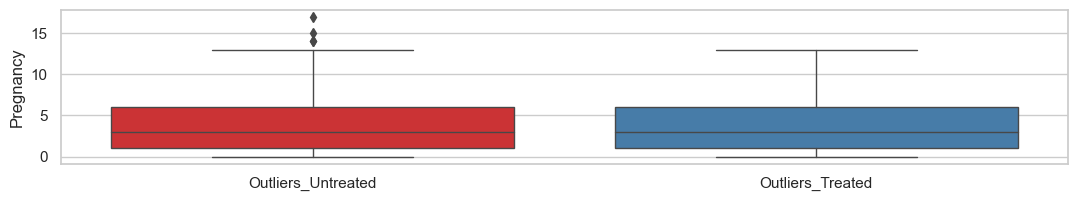

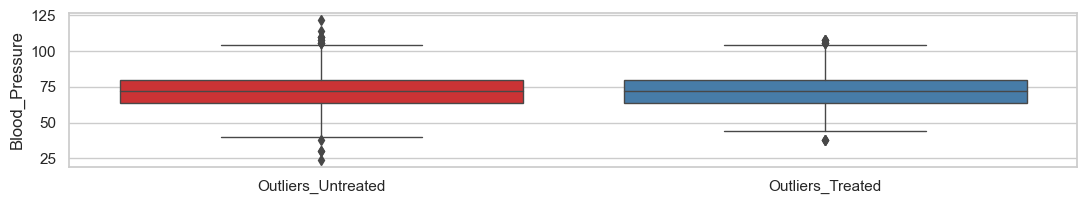

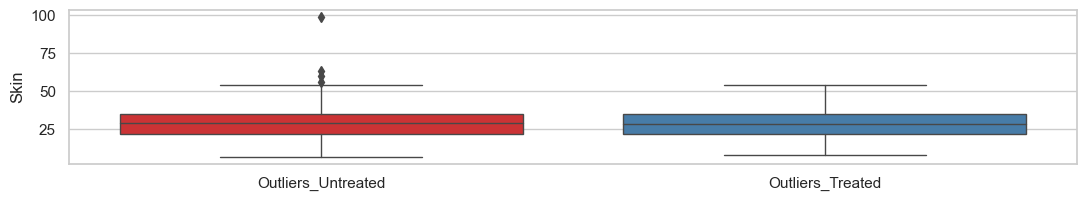

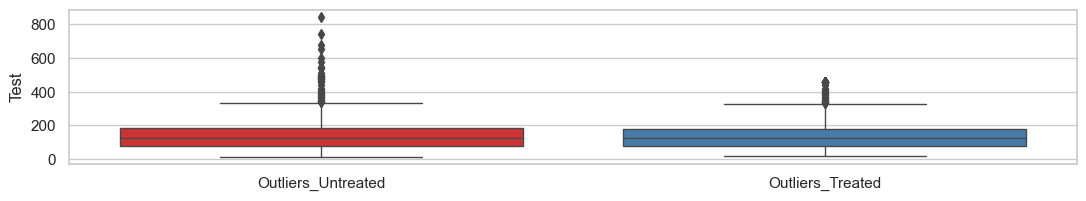

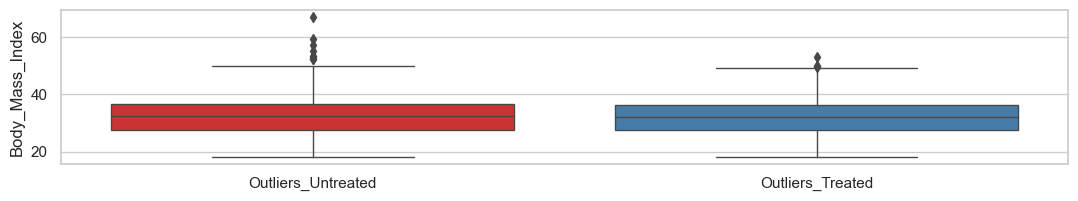

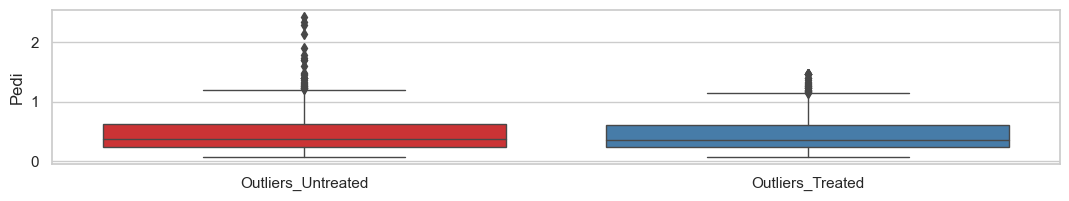

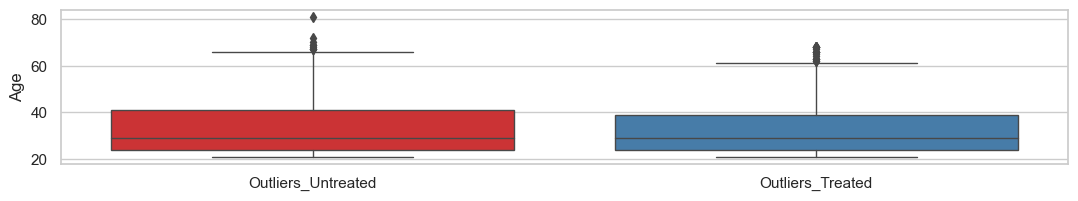

In [11]:
df_before = df_no_missing.copy()
df_before['condition']=['Outliers_Untreated']*df_before.shape[0]
df_after  = df_clean.copy()
df_after['condition'] =['Outliers_Treated']*df_after.shape[0]
df_before_after = pd.concat([df_before,df_after],axis=0)
df_before_after.head()

x   = 'condition'
for y in columns_with_outliers:
    df = df_before_after[ [x,y] ].copy().dropna().sort_values([x],ascending=[False]) 
    # BoxPlot
    sns.set(rc={'figure.figsize':(13,2)}); sns.set(style='whitegrid')
    sns_plot = sns.boxplot( x=x, y=y, data=df, linewidth=1.0, palette='Set1'); sns_plot.set_xlabel('')
    fig = sns_plot.get_figure(); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - As expected, notable reduction in range and amount of outliers is achieved.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Feature Selection

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Correlations

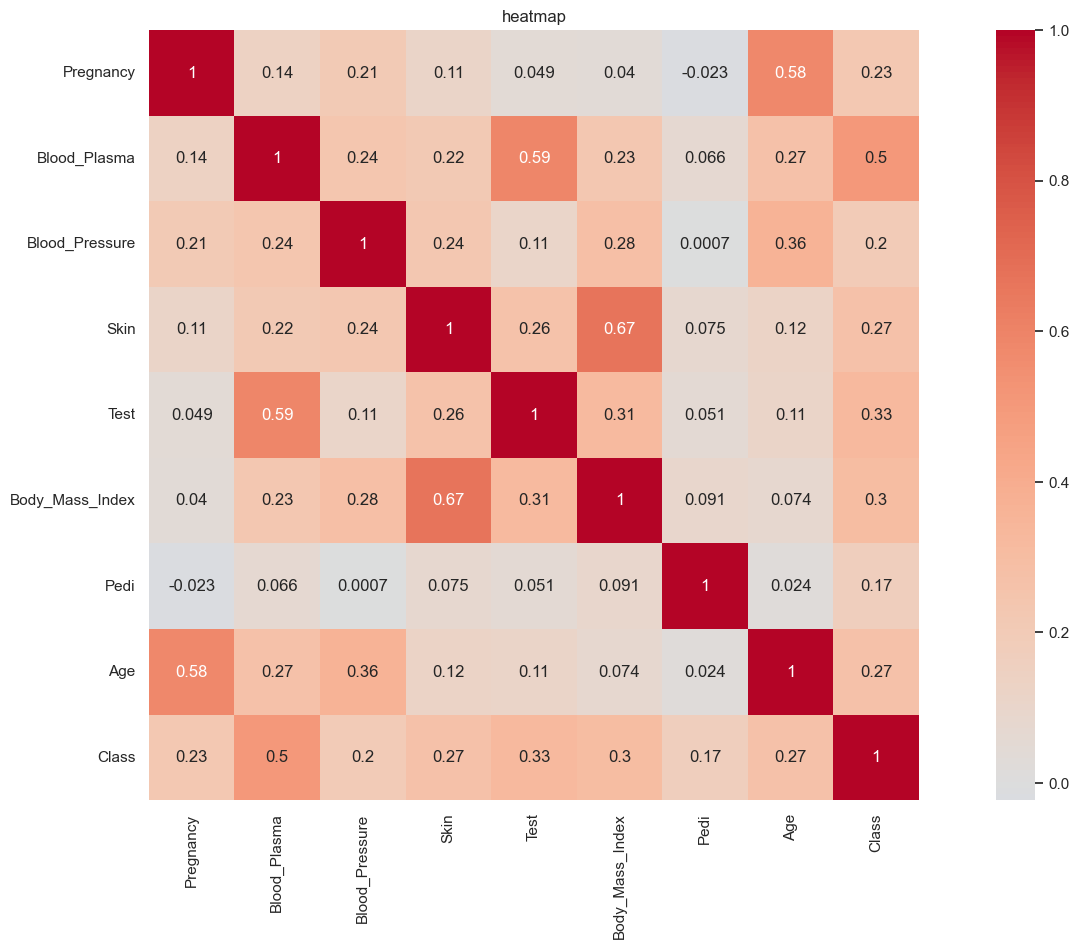

In [12]:
# heatmap
df = df_clean.copy() 

sns.set(style='whitegrid')
corr = df.corr('pearson')

fig,ax = plt.subplots(figsize=(20,10))
sns_plot = sns.heatmap( corr, mask=np.zeros_like(corr,dtype=bool), 
                        cmap='coolwarm',
                        square=True, ax=ax, annot=True, center=0.00 )
sns_plot.set( title="heatmap" )
 
fig = sns_plot.get_figure() 
fig.savefig('heatmap.png')

plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Chi-Squared Test

In [13]:
# Chi-Square Test
from sklearn.feature_selection import chi2 

# df
df = df_clean.copy()

X = df.drop([estimated_column],axis=1) 
y = df[estimated_column]
X_pvals = chi2(X,y)

# feature p values
# p value <= 0.05  means  strong feature
ft_pvals = pd.Series( X_pvals[1] )
ft_pvals.index = X.columns

# important & unimportant features
important_features   = list( ft_pvals[ft_pvals<=0.05].sort_values( ascending=True ).index )
unimportant_features = list( ft_pvals[ft_pvals> 0.05].sort_values( ascending=True ).index )

print( '\nChi-Squares P-Value Results:\n' )
print(    pd.DataFrame(ft_pvals,columns=['P_Value'])   )
print( '\n  Important_features:',   important_features )
print( '\nUnImportant_features:', unimportant_features )


Chi-Squares P-Value Results:

                       P_Value
Pregnancy         3.408920e-24
Blood_Plasma     1.571379e-289
Blood_Pressure    9.593018e-14
Skin              1.257707e-34
Test              0.000000e+00
Body_Mass_Index   1.027407e-19
Pedi              5.657509e-02
Age               5.588602e-46

  Important_features: ['Test', 'Blood_Plasma', 'Age', 'Skin', 'Pregnancy', 'Body_Mass_Index', 'Blood_Pressure']

UnImportant_features: ['Pedi']


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - Diabetes Class:
   - Extremely Depends on Features [ Test, Blood_Plasma ]
   - Highly Depends on Features [ Age, Skin, Pregnancy, Body_Mass_Index, Blood_Pressure ]
   - BUT is not dependent on Feature [ Pedi ].
 So, Feature [ Pedi ] Can Be Deleted.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning Important Features
 - (Removing UnImportant Features)

In [14]:
df                     = df_clean[ important_features ].copy()
df[ estimated_column ] = df_clean[  estimated_column  ].copy()
df_clean               = df.copy()

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Train Test DataSets

In [15]:
df = df_clean.copy().sort_values(['Class'],ascending=True)

# (auto)
X = df.drop( estimated_column, axis=1 ).copy() 
y = df[ estimated_column ].copy() 
 
X_Train, X_Test, y_Train, y_Test  =  train_test_split(        
          X, LabelEncoder().fit(y).transform(y)
        , random_state  =  3
        , test_size     =  0.20
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train.index = range( X_Train.shape[0] )
X_Test.index  = range( X_Test.shape[0]  ) 

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checking Imbalance in Data

col_0  count
Class       
0        482
1        247


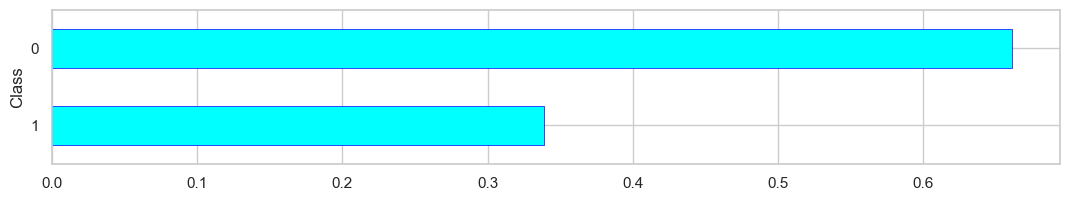

In [16]:
df = df_clean.copy()
x  = estimated_column

# Frequency Table  
freq_tab = pd.crosstab( index=df[x].astype('str'), columns='count' )
print(freq_tab.sort_values('count',ascending=False))

# Barh
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan'); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - Data is **Imbalanced** and needs treatment.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Treating Imbalance

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Imbalance by SMOTETomek

In [17]:
nClasses = len( df_clean[estimated_column].astype('str').unique() )

Sampler = SMOTETomek()
X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train, y_Train )
X_Test_Balanced,  y_Test_Balanced  = Sampler.fit_resample( X_Test,  y_Test  )
X_Train_Balanced.index = range(X_Train_Balanced.shape[0])
X_Test_Balanced.index  = range(X_Test_Balanced.shape[0])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checking Balanced Data

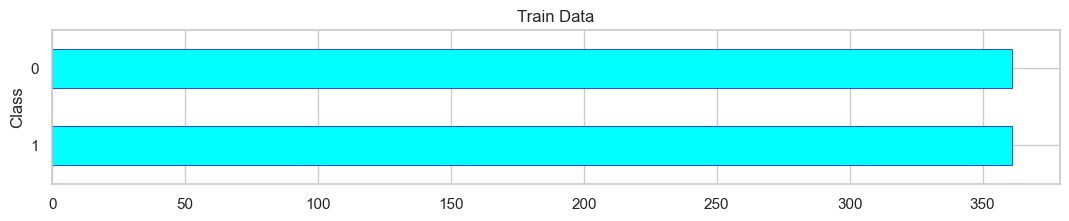

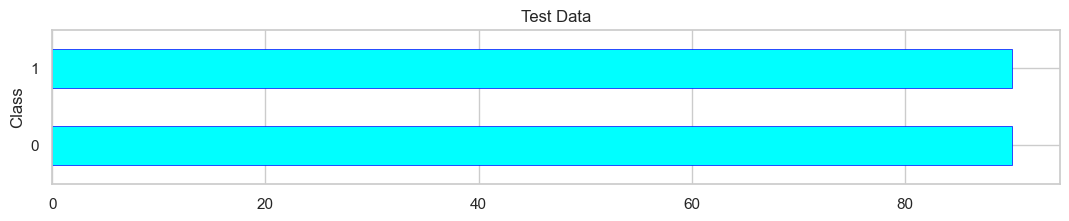

In [18]:
df_Train_Balanced            = X_Train_Balanced.copy()
df_Train_Balanced[ 'Class' ] = y_Train_Balanced.copy()

df_Test_Balanced             = X_Test_Balanced.copy()
df_Test_Balanced[ 'Class' ]  = y_Test_Balanced.copy()

x  = 'Class' 

# Train Data
df = df_Train_Balanced.copy() 
L = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Train Data'); plt.show()

# Test Data
df = df_Test_Balanced.copy()
L = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Test Data'); plt.show()


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - After Treatment, Data is **Balanced**

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning 

In [19]:
X_Train = X_Train_Balanced.copy();           y_Train = y_Train_Balanced.copy()
X_Test  = X_Test_Balanced.copy();            y_Test  = y_Test_Balanced.copy()
X_Clean = df_clean.drop(['Class'],axis=1);   y_Clean = np.array(df_clean['Class'])

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Balanced Training Variables

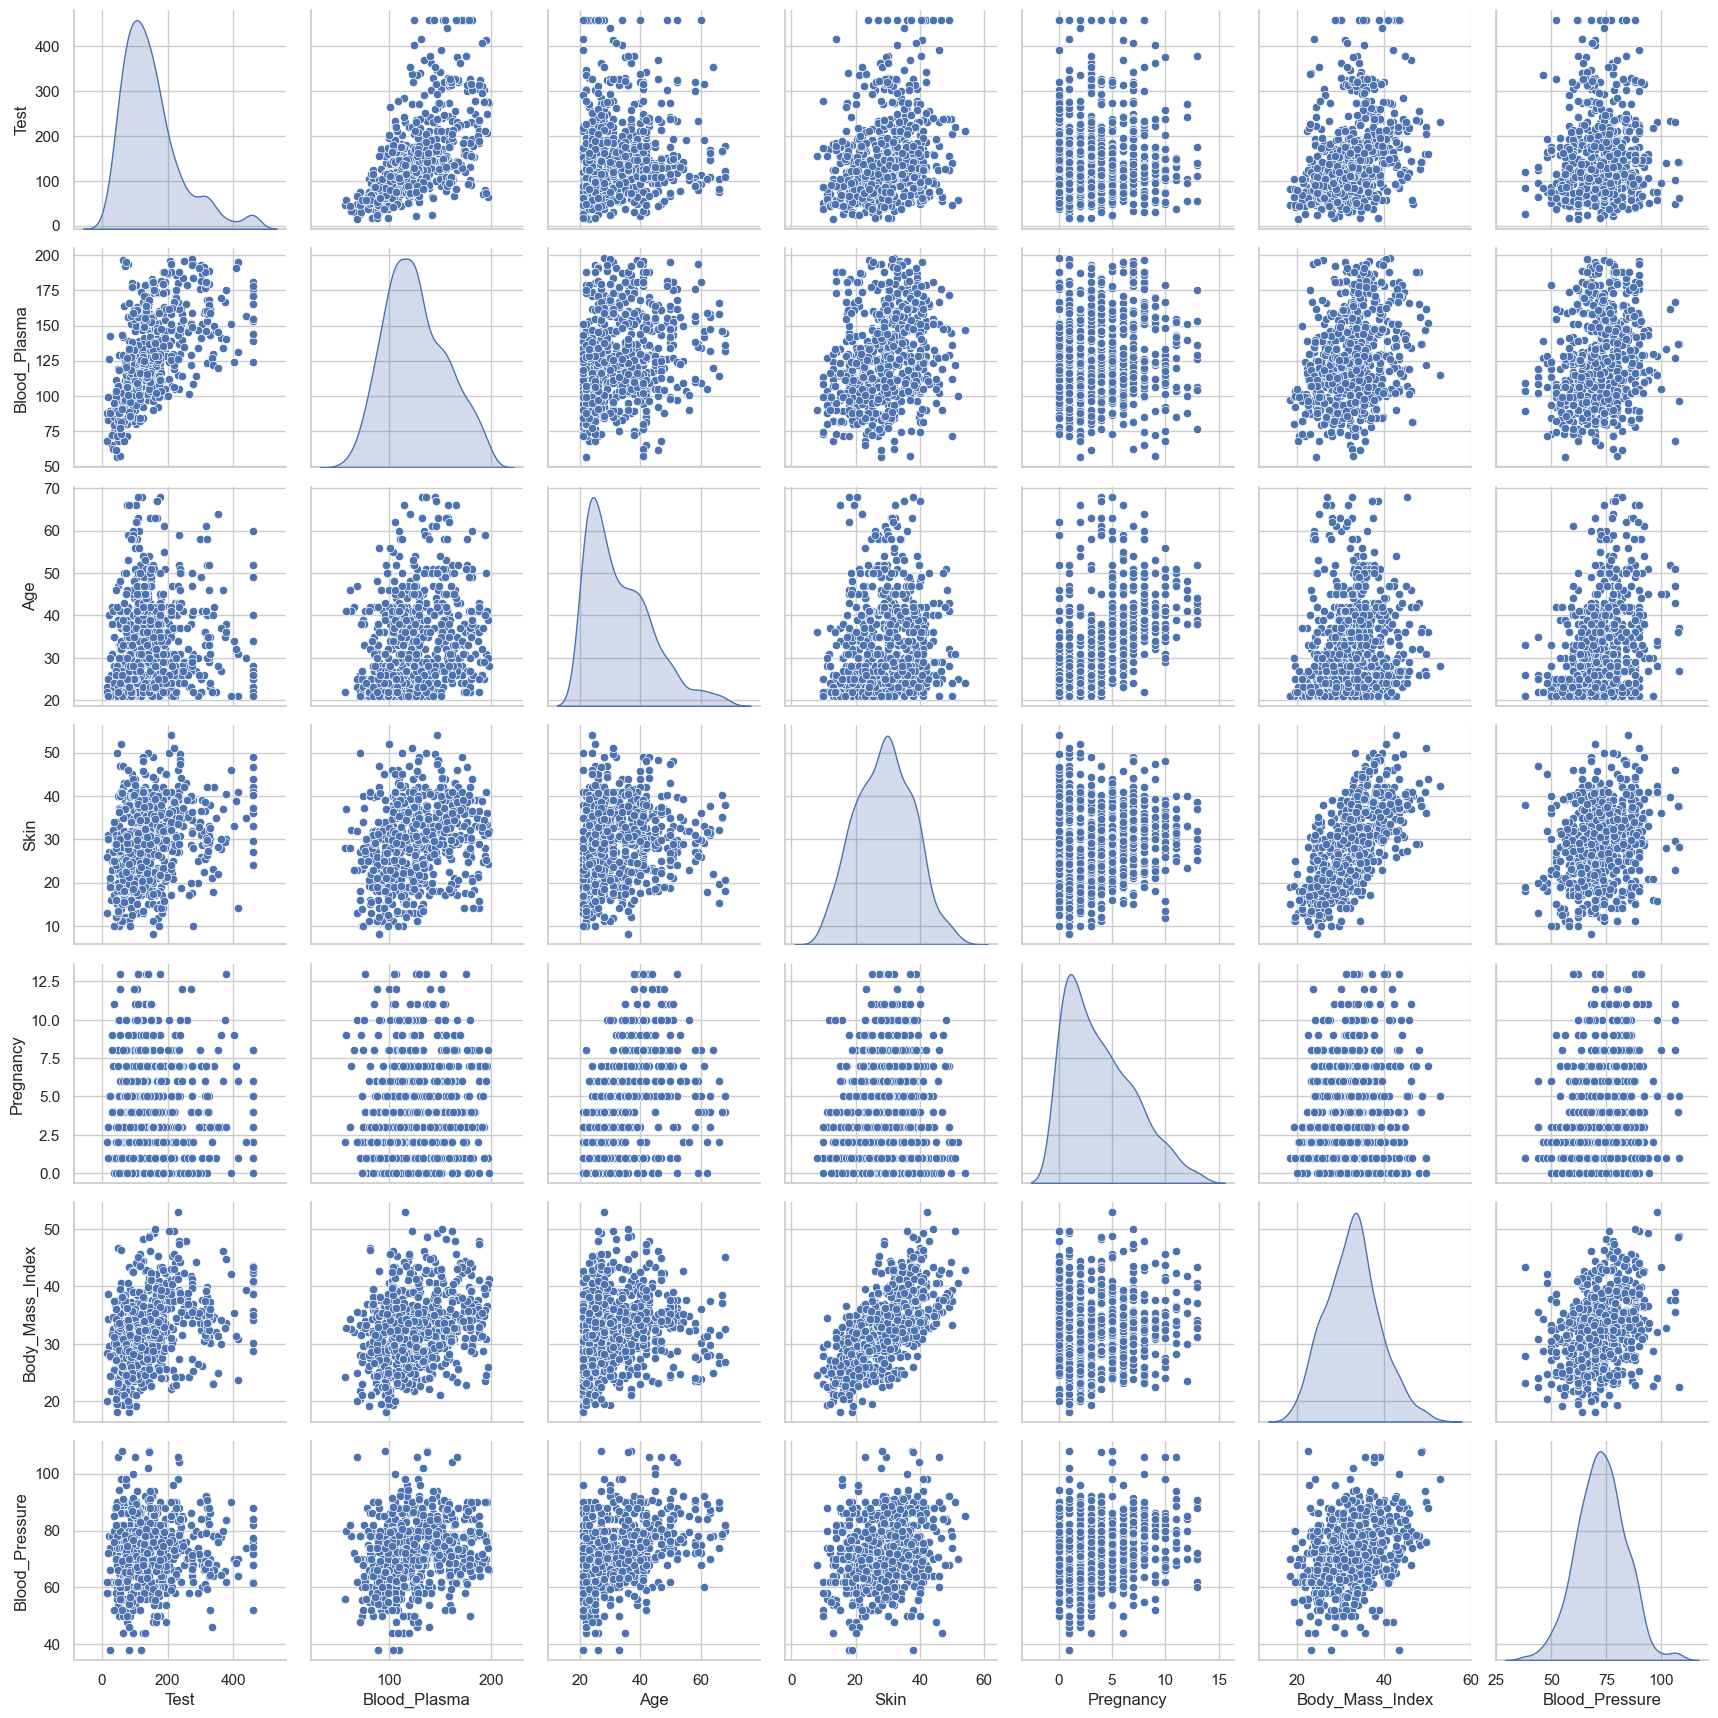

In [20]:
sns.pairplot( X_Train, diag_kind='kde' ); plt.show()

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [21]:
from openpyxl       import Workbook
from openpyxl.utils import get_column_letter
from openpyxl       import load_workbook

wb = Workbook()
dest_filename = 'Balanced_DataSets.xlsx'
Empty = wb.active; Empty.title='Empty'     


XX = df_clean.values.copy()    
dfClean = wb.create_sheet('dfClean')
dfClean.append( list(df_clean.columns) )
for i in range( XX.shape[0] ): dfClean.append( list( XX[i,:] )  )

    
XX = X_Train.values.copy()    
xTrain = wb.create_sheet('xTrain')
xTrain.append( list(X_Train.columns) )
for i in range( XX.shape[0] ): xTrain.append( list( XX[i,:] )  )
                                                  
YY = y_Train.copy()    
yTrain = wb.create_sheet('yTrain')
yTrain.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTrain.append([  YY[i], YY[i]  ])

    
XX = X_Test.values.copy()    
xTest = wb.create_sheet('xTest')
xTest.append( list(X_Test.columns) )
for i in range( XX.shape[0] ): xTest.append( list( XX[i,:] )  )
                                                  
YY = y_Test.copy()    
yTest = wb.create_sheet('yTest')
yTest.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTest.append([  YY[i], YY[i]  ])
    
    
XX = X_Clean.values.copy()    
xClean = wb.create_sheet('xClean')
xClean.append( list(X_Clean.columns) )
for i in range( XX.shape[0] ): xClean.append( list( XX[i,:] )  )
                                                  
YY = y_Clean.copy()    
yClean = wb.create_sheet('yClean')
yClean.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yClean.append([  YY[i], YY[i]  ])

    
# Saving    
wb.save( filename = dest_filename )   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [22]:
DataSet  = 'Balanced_DataSets.xlsx'

df_clean =           pd.read_excel( DataSet, 'dfClean', header=0 )

X_Train  =           pd.read_excel( DataSet, 'xTrain', header=0 )
y_Train  = np.array( pd.read_excel( DataSet, 'yTrain', header=0 ).iloc[:,0] )

X_Test   =           pd.read_excel( DataSet, 'xTest',  header=0 )
y_Test   = np.array( pd.read_excel( DataSet, 'yTest',  header=0 ).iloc[:,0] )

X_Clean  =           pd.read_excel( DataSet, 'xClean',  header=0 )
y_Clean  = np.array( pd.read_excel( DataSet, 'yClean',  header=0 ).iloc[:,0] )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Scaling Datasets

In [23]:
x_train_scaled, y_train =  scale(X_Train) , y_Train
x_test_scaled,  y_test  =  scale(X_Test)  , y_Test
x_clean_scaled, y_clean =  scale(X_Clean) , y_Clean

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Base-Line

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making A Base-Line for Gaussian Naive Bayes Estimators

In [24]:
GaussianNB_BaseLine = GaussianNB( ).fit( x_train_scaled, y_train )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Evaluating The BaseLine
 - As the dataset has been tampered (balanced), Evaluation is done on the whole cleaned dataset (df_clean)

In [25]:
y_pred = GaussianNB_BaseLine.predict( x_clean_scaled )
BaseLine_Report = classification_report( y_clean, y_pred )
print( BaseLine_Report )

              precision    recall  f1-score   support

           0       0.88      0.69      0.77       482
           1       0.57      0.81      0.67       247

    accuracy                           0.73       729
   macro avg       0.73      0.75      0.72       729
weighted avg       0.77      0.73      0.74       729



** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Gaussian Naive Bayes Estimators

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [26]:
# Needed Data
N_SPLITS = 10

# cross-validation strategy 
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# Hyper Parameters
CATs  = [  
        ]
TFs   = [ 
        ]
INTs  = [  
        ]
CONTs = [ [ 'var_smoothing', 1e-3, 1.0, 1.0, 'log-uniform' ]
        ] 
            
# General Estimator 
ESTIMATOR  =  GaussianNB( priors = None
                        ) 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Hyper-Parameter Tuning by Genetic Algorithm

initiating ...


C:\Users\EZ-Tech\AppData\Roaming\Python\Python310\site-packages\sklearn_genetic\genetic_search.py:279: UserWarning: Warning, only one parameter was provided to the param_grid, the optimization routine might not have effect or it could lead to errors, it's advised to use at least 2 parameters
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	500   	0.743937	0.00307614 	0.752074   	0.735483   
1  	908   	0.752062	6.04668e-05	0.752074   	0.75078    
2  	894   	0.752162	4.77442e-05	0.752188   	0.752074   


Best Parameters: {'var_smoothing': 0.03624494060846576}
accuracy = 0.7


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


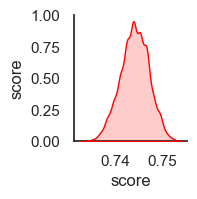


optimizing_time (min) = 2.0


In [27]:
# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , x_train_scaled, y_train, x_test_scaled, y_test ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=3, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( x_train_scaled, y_train, callbacks = callbacks )

    accuracy = optimal_params.score( x_test_scaled, y_test )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ] 



# Initiating
t1 = time.time()

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 500,2,1500, .30,.60 
Search_Space_Features   = [ 'score' ]
Best_Params, Top_Params = GA_Search(CATs,TFs,INTs,CONTs,ESTIMATOR,CV,Search_Space_Features,SCORING,
                                    Pop_Size,Gens,Tours,Crossover,Mutation, x_train_scaled, y_train, x_test_scaled, y_test )

t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Viewing Top Hyper-Parameters

In [28]:
for i in range(5): print('\n\n\n', Top_Params[i] )




 {'index': 0, 'var_smoothing': 0.10193093310163269, 'score': 0.7438736681887367, 'cv_scores': array([0.67123288, 0.73972603, 0.70833333, 0.80555556, 0.84722222,
       0.72222222, 0.70833333, 0.73611111, 0.79166667, 0.70833333]), 'fit_time': array([0.00299907, 0.00299978, 0.00299835, 0.00299883, 0.00199842,
       0.00199938, 0.00299835, 0.0029974 , 0.00299859, 0.00299811]), 'score_time': array([0.00199795, 0.00199914, 0.00199938, 0.00199699, 0.0039959 ,
       0.00499606, 0.00099969, 0.0010004 , 0.00099945, 0.00199795]), 'test_score': array([0.67123288, 0.73972603, 0.70833333, 0.80555556, 0.84722222,
       0.72222222, 0.70833333, 0.73611111, 0.79166667, 0.70833333]), 'train_score': array([0.75192604, 0.75192604, 0.75384615, 0.74461538, 0.73846154,
       0.74769231, 0.74615385, 0.74769231, 0.74307692, 0.74923077])}



 {'index': 1, 'var_smoothing': 0.004849564541007452, 'score': 0.7410768645357686, 'cv_scores': array([0.7260274 , 0.69863014, 0.72222222, 0.73611111, 0.75      ,
   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Top Estimators

In [29]:
GaussianNB_ = GaussianNB( priors=None , var_smoothing=0.036244940608465760 ).fit( x_train_scaled, y_train )
GaussianNB0 = GaussianNB( priors=None , var_smoothing=0.101930933101632690 ).fit( x_train_scaled, y_train )
GaussianNB1 = GaussianNB( priors=None , var_smoothing=0.004849564541007400 ).fit( x_train_scaled, y_train )
GaussianNB2 = GaussianNB( priors=None , var_smoothing=0.016953584346364403 ).fit( x_train_scaled, y_train )
GaussianNB3 = GaussianNB( priors=None , var_smoothing=0.014494465724323355 ).fit( x_train_scaled, y_train )
GaussianNB4 = GaussianNB( priors=None , var_smoothing=0.047001526941470270 ).fit( x_train_scaled, y_train )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checking Accuracy, Recall & Precision of Top Estimators

In [30]:
ESTIMATORS = [ GaussianNB_, GaussianNB0, GaussianNB1, GaussianNB2, GaussianNB3, GaussianNB4 ]
ACCURACIS, RECALLS, PRECISIONS = [],[],[]


for estimator in ESTIMATORS:
    y_pred  = estimator.predict( x_test_scaled )
    
    A_Score =  accuracy_score(y_test, y_pred,        normalize=True        )
    R_Score =    recall_score(y_test, y_pred, average=None, zero_division=1)  
    P_Score = precision_score(y_test, y_pred, average=None, zero_division=1)
    
    A_Score=np.round(A_Score*100,1);   ACCURACIS.append(A_Score)
    R_Score=np.round(R_Score*100,1);     RECALLS.append(R_Score)
    P_Score=np.round(P_Score*100,1);  PRECISIONS.append(P_Score)
    
Estimators_ARP = pd.DataFrame([ACCURACIS,RECALLS,PRECISIONS]).T
Estimators_ARP.columns = [ 'Accuracy','Recall','Precision' ]
Estimators_ARP.index   = [ 'GaussianNB_', 'GaussianNB0', 'GaussianNB1', 'GaussianNB2', 'GaussianNB3', 'GaussianNB4' ]

Estimators_ARP

,Accuracy,Recall,Precision
GaussianNB_,70.0,"[75.6, 64.4]","[68.0, 72.5]"
GaussianNB0,70.0,"[75.6, 64.4]","[68.0, 72.5]"
GaussianNB1,70.0,"[75.6, 64.4]","[68.0, 72.5]"
GaussianNB2,70.0,"[75.6, 64.4]","[68.0, 72.5]"
GaussianNB3,70.0,"[75.6, 64.4]","[68.0, 72.5]"
GaussianNB4,70.0,"[75.6, 64.4]","[68.0, 72.5]"


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - All Estimators Have Accuracy, Recall or Precision **< 80%** and are weak!

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Gradient Boosting Top Estimators

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [31]:
# Needed Data
N_SPLITS     = 10

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (auto)
if nClasses == 2:
    LOSS_VALUES = ['log_loss','exponential']
else:
    LOSS_VALUES = ['log_loss']

# Hyper Parameters
CATs  = [ ['loss'        ,      LOSS_VALUES                 ]   
        , ['criterion'   , ['friedman_mse','squared_error'] ] 
        , ['max_features', ['sqrt','log2',None]             ]  
        ]
TFs   = [ ['warm_start']
        ]
INTs  = [ ['max_depth'     ,            1, 15, 15           ]
        , ['max_leaf_nodes',            2, 16, 15           ]  
        ]
CONTs = [ [ 'tol'                     ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'ccp_alpha'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'subsample'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'learning_rate'           ,   1e-3, 0.3, 4,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 4,   'log-uniform' ]
        ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Hyper-Parameter Tuning by Genetic Algorithm



# 0
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	300   	0.73376	0.0368797  	0.800533   	0.50137    
1  	549   	0.794291	0.00447435 	0.796556   	0.774258   
2  	542   	0.820955	0.000665352	0.821271   	0.818474   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': None, 'warm_start': True, 'max_depth': 13, 'max_leaf_nodes': 11, 'tol': 0.011665917846155763, 'ccp_alpha': 0.0010493835131812276, 'subsample': 0.9904716224637996, 'learning_rate': 0.17797554810873348, 'min_samples_leaf': 0.002074173030749331, 'min_samples_split': 0.08775510587829072, 'min_impurity_decrease': 0.35478364691703745, 'min_weight_fraction_leaf': 0.04935662161857324}
accuracy = 0.7111111111111111


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


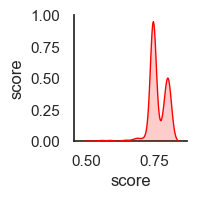


optimizing_time (min) = 14.0


# 1
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	300   	0.732988	0.0453216  	0.785426   	0.49863    
1  	548   	0.791218	0.00194262 	0.79218    	0.781145   
2  	538   	0.804327	0.00118518 	0.804661   	0.797755   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'warm_start': True, 'max_depth': 11, 'max_leaf_nodes': 8, 'tol': 0.009403489438655786, 'ccp_alpha': 0.0038875671470569484, 'subsample': 0.1589970913630801, 'learning_rate': 0.0834034005512379, 'min_samples_leaf': 0.012484140668547894, 'min_samples_split': 0.001956286461279281, 'min_impurity_decrease': 0.05111356754838823, 'min_weight_fraction_leaf': 0.08889068043793422}
accuracy = 0.7722222222222223


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


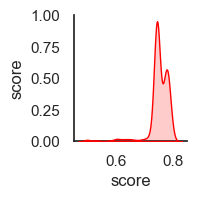


optimizing_time (min) = 11.0


# 2
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	300   	0.735841	0.0349504  	0.796442   	0.49863    
1  	541   	0.801682	0.00545663 	0.804585   	0.783999   
2  	543   	0.818557	0.000310142	0.818626   	0.814441   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': 'log2', 'warm_start': False, 'max_depth': 14, 'max_leaf_nodes': 14, 'tol': 0.09901912537258353, 'ccp_alpha': 0.003968855629302616, 'subsample': 0.5675653340724792, 'learning_rate': 0.23975937905512665, 'min_samples_leaf': 0.0031771418612652723, 'min_samples_split': 0.009629101653603934, 'min_impurity_decrease': 0.012135369780594513, 'min_weight_fraction_leaf': 0.03908422041273322}
accuracy = 0.6833333333333333


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


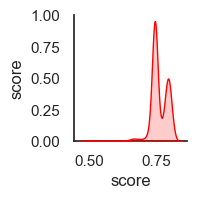


optimizing_time (min) = 12.0


# 3
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	300   	0.734238	0.0447915  	0.78535    	0.5        
1  	534   	0.790322	0.00213759 	0.790963   	0.779585   
2  	553   	0.808915	0.000401833	0.80898    	0.806107   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'warm_start': False, 'max_depth': 7, 'max_leaf_nodes': 15, 'tol': 0.13942770960590545, 'ccp_alpha': 0.008036007901876165, 'subsample': 0.07149185379546669, 'learning_rate': 0.2571751337634352, 'min_samples_leaf': 0.0014569737173863813, 'min_samples_split': 0.0012465174423654315, 'min_impurity_decrease': 0.003677681986957427, 'min_weight_fraction_leaf': 0.005924532046024115}
accuracy = 0.8


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


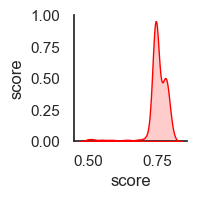


optimizing_time (min) = 12.0


# 4
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	300   	0.732823	0.0456706  	0.792218   	0.49863    
1  	550   	0.799027	0.00654708 	0.802055   	0.779833   
2  	540   	0.820746	0.00111711 	0.82129    	0.815791   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'warm_start': True, 'max_depth': 6, 'max_leaf_nodes': 15, 'tol': 0.01340571553773427, 'ccp_alpha': 0.0017705639652049014, 'subsample': 0.37173774168632884, 'learning_rate': 0.18115832413136707, 'min_samples_leaf': 0.0014902630186335278, 'min_samples_split': 0.00356557614796246, 'min_impurity_decrease': 0.07518662966568761, 'min_weight_fraction_leaf': 0.049056583990484924}
accuracy = 0.7444444444444445


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


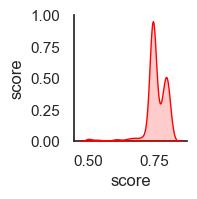


optimizing_time (min) = 12.0


# 5
initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	300   	0.738266	0.0285214  	0.785312   	0.520548   
1  	550   	0.794278	0.00450356 	0.796461   	0.77696    
2  	542   	0.812933	0.00034633 	0.813014   	0.810236   


Best Parameters: {'loss': 'exponential', 'criterion': 'friedman_mse', 'max_features': None, 'warm_start': False, 'max_depth': 5, 'max_leaf_nodes': 8, 'tol': 0.002966721002279606, 'ccp_alpha': 0.007813869292358435, 'subsample': 0.13144672035048446, 'learning_rate': 0.13080831531078205, 'min_samples_leaf': 0.00896383397890979, 'min_samples_split': 0.001348442927525736, 'min_impurity_decrease': 0.012409499519345134, 'min_weight_fraction_leaf': 0.044152684941325814}
accuracy = 0.7333333333333333


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


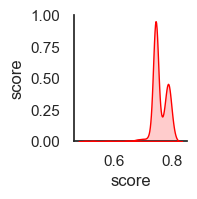


optimizing_time (min) = 11.0


In [32]:
# Initiations
INITs = [ GaussianNB0, GaussianNB1, GaussianNB2, GaussianNB3, GaussianNB4, GaussianNB_ ]

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 300,2,900, .40,.50 
Search_Space_Features = [ 'score' ]

for i in range( len(INITs) ):
    print( '\n\n#', i )
    # Initiating
    t1 = time.time()
    # General Estimator 
    ESTIMATOR  =  GradientBoostingClassifier( init            = INITs[i]
                                        , n_estimators        = 50
                                        , random_state        = RANDOM_STATE
                                        , verbose             = 0
                                        , n_iter_no_change    = None
                                        , validation_fraction = 0.1 
                                        )   
    Best_Params, Top_Params = GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR, CV, Search_Space_Features, SCORING,
                                     Pop_Size,Gens,Tours,Crossover,Mutation, 
                                     x_train_scaled, y_train, x_test_scaled, y_test )
    t2 = time.time()
    dt = np.round( (t2-t1)/60, 0 )
    print( '\noptimizing_time (min) =', dt )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Gradient  Boosted Gaussian Naive Bayes Estimators

In [33]:
GaussianNB0_GrBoosted = GradientBoostingClassifier( init=GaussianNB0,
    loss='exponential', criterion='friedman_mse', max_features=None, warm_start=True, max_depth=13, max_leaf_nodes=11, 
    tol=0.011665917846155763, ccp_alpha=0.0010493835131812276, subsample=0.9904716224637996, 
    learning_rate=0.17797554810873348, min_samples_leaf=0.002074173030749331, min_samples_split=0.08775510587829072, 
    min_impurity_decrease=0.35478364691703745, min_weight_fraction_leaf=0.04935662161857324,
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

GaussianNB1_GrBoosted = GradientBoostingClassifier( init=GaussianNB1,  
    loss='exponential', criterion='friedman_mse', max_features='sqrt', warm_start=True, max_depth=11, max_leaf_nodes=8,
    tol=0.009403489438655786, ccp_alpha=0.0038875671470569484, subsample=0.1589970913630801, 
    learning_rate=0.0834034005512379, min_samples_leaf=0.012484140668547894, min_samples_split=0.001956286461279281, 
    min_impurity_decrease=0.05111356754838823, min_weight_fraction_leaf=0.08889068043793422,
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

GaussianNB2_GrBoosted = GradientBoostingClassifier( init=GaussianNB2, 
    loss='exponential', criterion='friedman_mse', max_features='log2', warm_start=False, max_depth=14, max_leaf_nodes=14, 
    tol=0.09901912537258353, ccp_alpha=0.003968855629302616, subsample=0.5675653340724792, 
    learning_rate=0.23975937905512665, min_samples_leaf=0.0031771418612652723, min_samples_split=0.009629101653603934, 
    min_impurity_decrease=0.012135369780594513, min_weight_fraction_leaf=0.03908422041273322,    
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

GaussianNB3_GrBoosted = GradientBoostingClassifier( init=GaussianNB3,
    loss='exponential', criterion='friedman_mse', max_features='sqrt', warm_start=False, max_depth=7, max_leaf_nodes=15, 
    tol=0.13942770960590545, ccp_alpha=0.008036007901876165, subsample=0.07149185379546669, 
    learning_rate=0.2571751337634352, min_samples_leaf=0.0014569737173863813, min_samples_split=0.0012465174423654315, 
    min_impurity_decrease=0.003677681986957427, min_weight_fraction_leaf=0.005924532046024115,
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

GaussianNB4_GrBoosted = GradientBoostingClassifier( init=GaussianNB4,
    loss='exponential', criterion='friedman_mse', max_features='sqrt', warm_start=True, max_depth=6, max_leaf_nodes=15, 
    tol=0.01340571553773427, ccp_alpha=0.0017705639652049014, subsample=0.37173774168632884, 
    learning_rate=0.18115832413136707, min_samples_leaf=0.0014902630186335278, min_samples_split=0.00356557614796246, 
    min_impurity_decrease=0.07518662966568761, min_weight_fraction_leaf=0.049056583990484924,
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

GaussianNB_GrBoosted = GradientBoostingClassifier( init=GaussianNB_,
    loss='exponential', criterion='friedman_mse', max_features=None, warm_start=False, max_depth=5, max_leaf_nodes=8, 
    tol=0.002966721002279606, ccp_alpha=0.007813869292358435, subsample=0.13144672035048446, 
    learning_rate=0.13080831531078205, min_samples_leaf=0.00896383397890979, min_samples_split=0.001348442927525736, 
    min_impurity_decrease=0.012409499519345134, min_weight_fraction_leaf=0.044152684941325814,
    n_estimators=50, random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                                  ).fit( x_train_scaled, y_train )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checking Accuracy, Recall & Precision of Boosted Estimators

In [34]:
ESTIMATORS = [ GaussianNB_GrBoosted,  GaussianNB0_GrBoosted, GaussianNB1_GrBoosted,
               GaussianNB2_GrBoosted, GaussianNB3_GrBoosted, GaussianNB4_GrBoosted ]

ACCURACIS, RECALLS, PRECISIONS = [],[],[]

for estimator in ESTIMATORS:
    y_pred  = estimator.predict( x_test_scaled )
    
    A_Score =  accuracy_score(y_test, y_pred,        normalize=True        )
    R_Score =    recall_score(y_test, y_pred, average=None, zero_division=1)  
    P_Score = precision_score(y_test, y_pred, average=None, zero_division=1)
    
    A_Score=np.round(A_Score*100,0);   ACCURACIS.append(A_Score)
    R_Score=np.round(R_Score*100,0);     RECALLS.append(R_Score)
    P_Score=np.round(P_Score*100,0);  PRECISIONS.append(P_Score)
    
Estimators_ARP = pd.DataFrame([ACCURACIS,RECALLS,PRECISIONS]).T
Estimators_ARP.columns = [ 'Accuracy','Recalls','Precisions' ]
Estimators_ARP.index   = [ 'GaussianNB_GrBoosted' , 'GaussianNB0_GrBoosted', 'GaussianNB1_GrBoosted',
                           'GaussianNB2_GrBoosted', 'GaussianNB3_GrBoosted', 'GaussianNB4_GrBoosted' ]

Estimators_ARP

,Accuracy,Recalls,Precisions
GaussianNB_GrBoosted,73.0,"[70.0, 77.0]","[75.0, 72.0]"
GaussianNB0_GrBoosted,71.0,"[80.0, 62.0]","[68.0, 76.0]"
GaussianNB1_GrBoosted,77.0,"[79.0, 76.0]","[76.0, 78.0]"
GaussianNB2_GrBoosted,68.0,"[71.0, 66.0]","[67.0, 69.0]"
GaussianNB3_GrBoosted,80.0,"[77.0, 83.0]","[82.0, 78.0]"
GaussianNB4_GrBoosted,74.0,"[78.0, 71.0]","[73.0, 76.0]"


** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Stacker & Voter

In [35]:
level0 = list()
level0.append(( 'GaussianNB_'          , GaussianNB_           ))
level0.append(( 'GaussianNB0'          , GaussianNB0           )) 
level0.append(( 'GaussianNB1'          , GaussianNB1           )) 
level0.append(( 'GaussianNB2'          , GaussianNB2           )) 
level0.append(( 'GaussianNB3'          , GaussianNB3           )) 
level0.append(( 'GaussianNB4'          , GaussianNB4           ))  
level0.append(( 'GaussianNB_GrBoosted' , GaussianNB_GrBoosted  ))
level0.append(( 'GaussianNB0_GrBoosted', GaussianNB0_GrBoosted )) 
level0.append(( 'GaussianNB1_GrBoosted', GaussianNB1_GrBoosted )) 
level0.append(( 'GaussianNB2_GrBoosted', GaussianNB2_GrBoosted )) 
level0.append(( 'GaussianNB3_GrBoosted', GaussianNB3_GrBoosted )) 
level0.append(( 'GaussianNB4_GrBoosted', GaussianNB4_GrBoosted ))  

# define meta learner model
level1  =  LogisticRegression()

# define the stacking ensemble
Stacker =  StackingClassifier( estimators=level0, final_estimator=level1, cv=10, passthrough=True,
                               stack_method='predict_proba' ).fit( x_train_scaled, y_train )

# define the votinging ensemble
Voter   =    VotingClassifier( estimators=level0, voting='soft' ).fit( x_train_scaled, y_train ) 

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Comparing The Estimators

               Mean     SD       95% CI
>GaussianNB_  0.732  (0.108)  [0.52 0.95]
>GaussianNB0  0.732  (0.110)  [0.51 0.95]
>GaussianNB1  0.728  (0.110)  [0.51 0.95]
>GaussianNB2  0.730  (0.109)  [0.51 0.95]
>GaussianNB3  0.729  (0.109)  [0.51 0.95]
>GaussianNB4  0.731  (0.110)  [0.51 0.95]
>GaussianNB_GrBoosted  0.787  (0.082)  [0.62 0.95]
>GaussianNB0_GrBoosted  0.823  (0.094)  [0.64 1.01]
>GaussianNB1_GrBoosted  0.779  (0.102)  [0.58 0.98]
>GaussianNB2_GrBoosted  0.814  (0.089)  [0.64 0.99]
>GaussianNB3_GrBoosted  0.761  (0.100)  [0.56 0.96]
>GaussianNB4_GrBoosted  0.804  (0.089)  [0.63 0.98]
>Stacker  0.817  (0.087)  [0.64 0.99]
>Voter    0.792  (0.102)  [0.59 1.00]


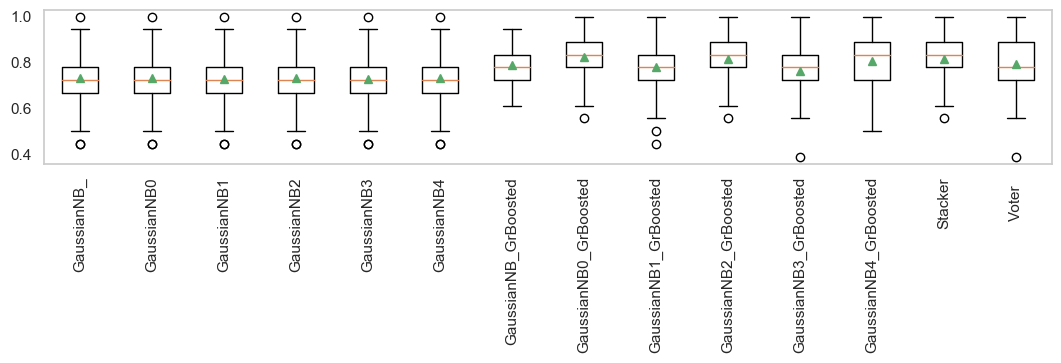

In [36]:
models = dict()
models['GaussianNB_'          ] = GaussianNB_
models['GaussianNB0'          ] = GaussianNB0
models['GaussianNB1'          ] = GaussianNB1
models['GaussianNB2'          ] = GaussianNB2
models['GaussianNB3'          ] = GaussianNB3
models['GaussianNB4'          ] = GaussianNB4
models['GaussianNB_GrBoosted' ] = GaussianNB_GrBoosted
models['GaussianNB0_GrBoosted'] = GaussianNB0_GrBoosted
models['GaussianNB1_GrBoosted'] = GaussianNB1_GrBoosted
models['GaussianNB2_GrBoosted'] = GaussianNB2_GrBoosted
models['GaussianNB3_GrBoosted'] = GaussianNB3_GrBoosted
models['GaussianNB4_GrBoosted'] = GaussianNB4_GrBoosted
models['Stacker'              ] = Stacker
models['Voter  '              ] = Voter

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=3)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
print('               Mean     SD       95% CI') 
for name, model in models.items():
    scores = evaluate_model( model, x_test_scaled, y_test )
    results.append(scores)
    names.append(name)
    print('>%s  %.3f  (%.3f)  [%.2f %.2f]' % (name, mean(scores), std(scores), mean(scores)-2*std(scores), mean(scores)+2*std(scores)   ))
    
# plot model performance for comparison
plt.boxplot( results, labels=names, showmeans=True ); plt.xticks(rotation=90); plt.grid(False); plt.show()

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - Stacker is one of the best estimators

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Evaluating Stacker

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing

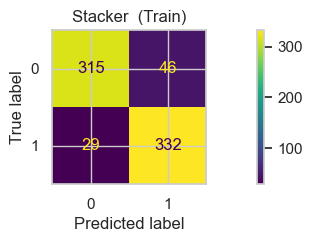

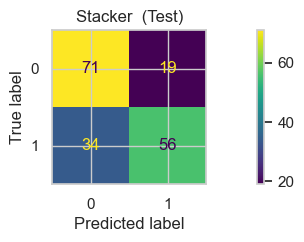

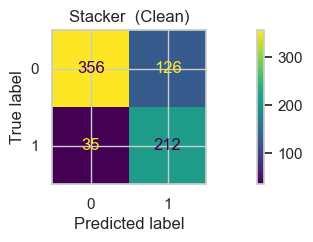

In [37]:
Classes  = ['0','1']
CLF      =  Stacker
CLF_Name = 'Stacker'

# Training Performance
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_train_scaled, y_train, display_labels=Classes  )
plt.title( CLF_Name+'  (Train)' ); plt.show()

# Test Performance
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_test_scaled,  y_test,  display_labels=Classes  )
plt.title( CLF_Name+'  (Test)' ); plt.show()

# Test Performance   
disp = ConfusionMatrixDisplay.from_estimator( CLF, x_clean_scaled, y_clean, display_labels=Classes  )
plt.title( CLF_Name+'  (Clean)' ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Stacker with BaseLine

In [38]:
y_pred = CLF.predict( x_clean_scaled )
Best_Report = classification_report( y_clean, y_pred )
print( '\n'+CLF_Name, '\n',   Best_Report   )
print( '\nBaseLine',  '\n', BaseLine_Report )


Stacker 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82       482
           1       0.63      0.86      0.72       247

    accuracy                           0.78       729
   macro avg       0.77      0.80      0.77       729
weighted avg       0.81      0.78      0.78       729


BaseLine 
               precision    recall  f1-score   support

           0       0.88      0.69      0.77       482
           1       0.57      0.81      0.67       247

    accuracy                           0.73       729
   macro avg       0.73      0.75      0.72       729
weighted avg       0.77      0.73      0.74       729



##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - Compared to BaseLine:
 
   - **precision** of class 0 **improved 3%**
   - **precision** of class 1 **improved 6%**
    
   - **recall** of class 0 **improved 5%**
   - **recall** of class 1 **improved 5%**
   
   - **accuracy improved 5%**

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Estimators To Disk

In [39]:
ESTIMATORS       = [  GaussianNB_,   GaussianNB0,   GaussianNB1,   GaussianNB2,   GaussianNB3,   GaussianNB4,
                      GaussianNB_GrBoosted,     GaussianNB0_GrBoosted,    GaussianNB1_GrBoosted,
                      GaussianNB2_GrBoosted,    GaussianNB3_GrBoosted,    GaussianNB4_GrBoosted,
                      Stacker,   Voter  ]

ESTIMATORS_Names = [ 'GaussianNB_', 'GaussianNB0', 'GaussianNB1', 'GaussianNB2', 'GaussianNB3', 'GaussianNB4',
                     'GaussianNB_GrBoosted',   'GaussianNB0_GrBoosted',  'GaussianNB1_GrBoosted',
                     'GaussianNB2_GrBoosted',  'GaussianNB3_GrBoosted',  'GaussianNB4_GrBoosted',
                     'Stacker', 'Voter' ]


for i in range( len(ESTIMATORS) ):
    Estimator        = ESTIMATORS[ i ]
    Destination_File = ESTIMATORS_Names[ i ]+'.sav'
    pickle.dump( Estimator, open(Destination_File,'wb') )



# load the model from disk
A = pickle.load( open(Destination_File,'rb') )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Estimators From Disk

In [40]:
GaussianNB_           = pickle.load( open( 'GaussianNB_.sav','rb') )
GaussianNB0           = pickle.load( open( 'GaussianNB0.sav','rb') )
GaussianNB1           = pickle.load( open( 'GaussianNB1.sav','rb') )
GaussianNB2           = pickle.load( open( 'GaussianNB2.sav','rb') )
GaussianNB3           = pickle.load( open( 'GaussianNB3.sav','rb') )
GaussianNB4           = pickle.load( open( 'GaussianNB4.sav','rb') )
GaussianNB_GrBoosted  = pickle.load( open( 'GaussianNB_GrBoosted.sav','rb') )
GaussianNB0_GrBoosted = pickle.load( open( 'GaussianNB0_GrBoosted.sav','rb') )
GaussianNB1_GrBoosted = pickle.load( open( 'GaussianNB1_GrBoosted.sav','rb') )
GaussianNB2_GrBoosted = pickle.load( open( 'GaussianNB2_GrBoosted.sav','rb') )
GaussianNB3_GrBoosted = pickle.load( open( 'GaussianNB3_GrBoosted.sav','rb') )
GaussianNB4_GrBoosted = pickle.load( open( 'GaussianNB4_GrBoosted.sav','rb') )
Stacker               = pickle.load( open( 'Stacker.sav','rb') )
Voter                 = pickle.load( open( 'Voter.sav','rb') )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making The Final Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checkig Range of Features

In [41]:
round( X_Train.describe().T[['min','max']], 3 )

,min,max
Test,15.0,459.165
Blood_Plasma,56.0,198.000
Age,21.0,68.000
Skin,8.0,54.000
Pregnancy,0.0,13.000
Body_Mass_Index,18.2,52.900
Blood_Pressure,38.0,108.000


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Choosing A Random Record To Be Predicted

In [42]:
# choosing a record in the test data set to be predicted
record_number = 2

df = X_Test.copy()
print( np.round( df.loc[  record_number  ,:], 1 ) )

print( '\nExpected_Class = ', y_Test[  record_number  ] )

Test               280.0
Blood_Plasma       196.0
Age                 57.0
Skin                29.0
Pregnancy            8.0
Body_Mass_Index     37.5
Blood_Pressure      76.0
Name: 2, dtype: float64

Expected_Class =  1


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Entering The Record of Interest and Acceptable Range

In [43]:
# input data                Range

Test            = 280.0    # 15.0 459.165
Blood_Plasma    = 196.0    # 56.0	198.000
Age             =  57.0    # 21.0 68.000
Skin            =  29.0    # 8.0 54.000
Pregnancy       =   8.0    # 0.0 13.000
Body_Mass_Index =  37.5    # 18.2 52.900
Blood_Pressure  =  76.0    # 38.0 108.000

#Class          =   1.0    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Predicting 

In [44]:
# x 
x = X_Train.copy()

# s  written in the same order as  X_Train
s = [ Test, Blood_Plasma, Age, Skin, Pregnancy, Body_Mass_Index, Blood_Pressure ]

encode_columns = [] 
def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    #print(sx_encoded.columns)
    sx_scaled = scale(  sx_encoded.iloc[1:,:]  )   
    sx_scaled = sx_scaled[[0,1]]  
    
    Estimator_Name, pred = [], [] 
    for key, value in models.items():
        clf = value
        Estimation = clf.predict( sx_scaled )[0]
        pred.append( Estimation ) 
        Estimator_Name.append( key )
        
    df_pred = pd.DataFrame( [pred] ).T
    df_pred.columns = ['Predicted Class']
    df_pred.index   = Estimator_Name
    
    return df_pred 

# Predicting
df_pred = predicted_class( s, x, encode_columns )
df_pred

,Predicted Class
GaussianNB_,1
GaussianNB0,1
GaussianNB1,1
GaussianNB2,1
GaussianNB3,1
GaussianNB4,1
GaussianNB_GrBoosted,1
GaussianNB0_GrBoosted,1
GaussianNB1_GrBoosted,1
GaussianNB2_GrBoosted,1


#####   

#####   